# Test plane-based registration

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os

import planeslam.io as io
from planeslam.general import plot_3D_setup, color_legend
from planeslam.scan import pc_to_scan
from planeslam.registration import extract_corresponding_features

%load_ext autoreload
%autoreload 2

In [20]:
from planeslam.geometry.util import skew

def expmap(w):
    """Exponential map w -> R"""
    theta = np.linalg.norm(w)
    u = w / theta
    return np.eye(3) + (np.sin(theta)) * skew(u) + ((1-np.cos(theta))) * np.linalg.matrix_power(skew(u), 2) 

In [21]:
w = np.random.rand(3)
R = expmap(w)
R @ R.T

array([[ 1.00000000e+00,  5.95939950e-17, -7.25621068e-17],
       [ 5.95939950e-17,  1.00000000e+00, -4.14659308e-17],
       [-7.25621068e-17, -4.14659308e-17,  1.00000000e+00]])

In [12]:
w

array([0.6201996 , 0.811607  , 0.47452467])

In [14]:
skew(w)**2

array([[0.        , 0.22517366, 0.65870592],
       [0.22517366, 0.        , 0.38464754],
       [0.65870592, 0.38464754, 0.        ]])

Test with single plane

In [60]:
from planeslam.geometry.plane import BoundedPlane
from scipy.spatial.transform import Rotation

import copy

V = np.array([[-1, 1, -1],
              [1, 1, -1],
              [1, 1, 1],
              [-1, 1, 1]])
P = BoundedPlane(V)

# Ground-truth transformation
t = np.array([0, 0, 0])[:,None]
r = Rotation.from_euler('xyz',[20, 45, 0], degrees=True)

R = r.as_matrix()

In [61]:
Q = copy.copy(P)
Q.transform(R, t.flatten())

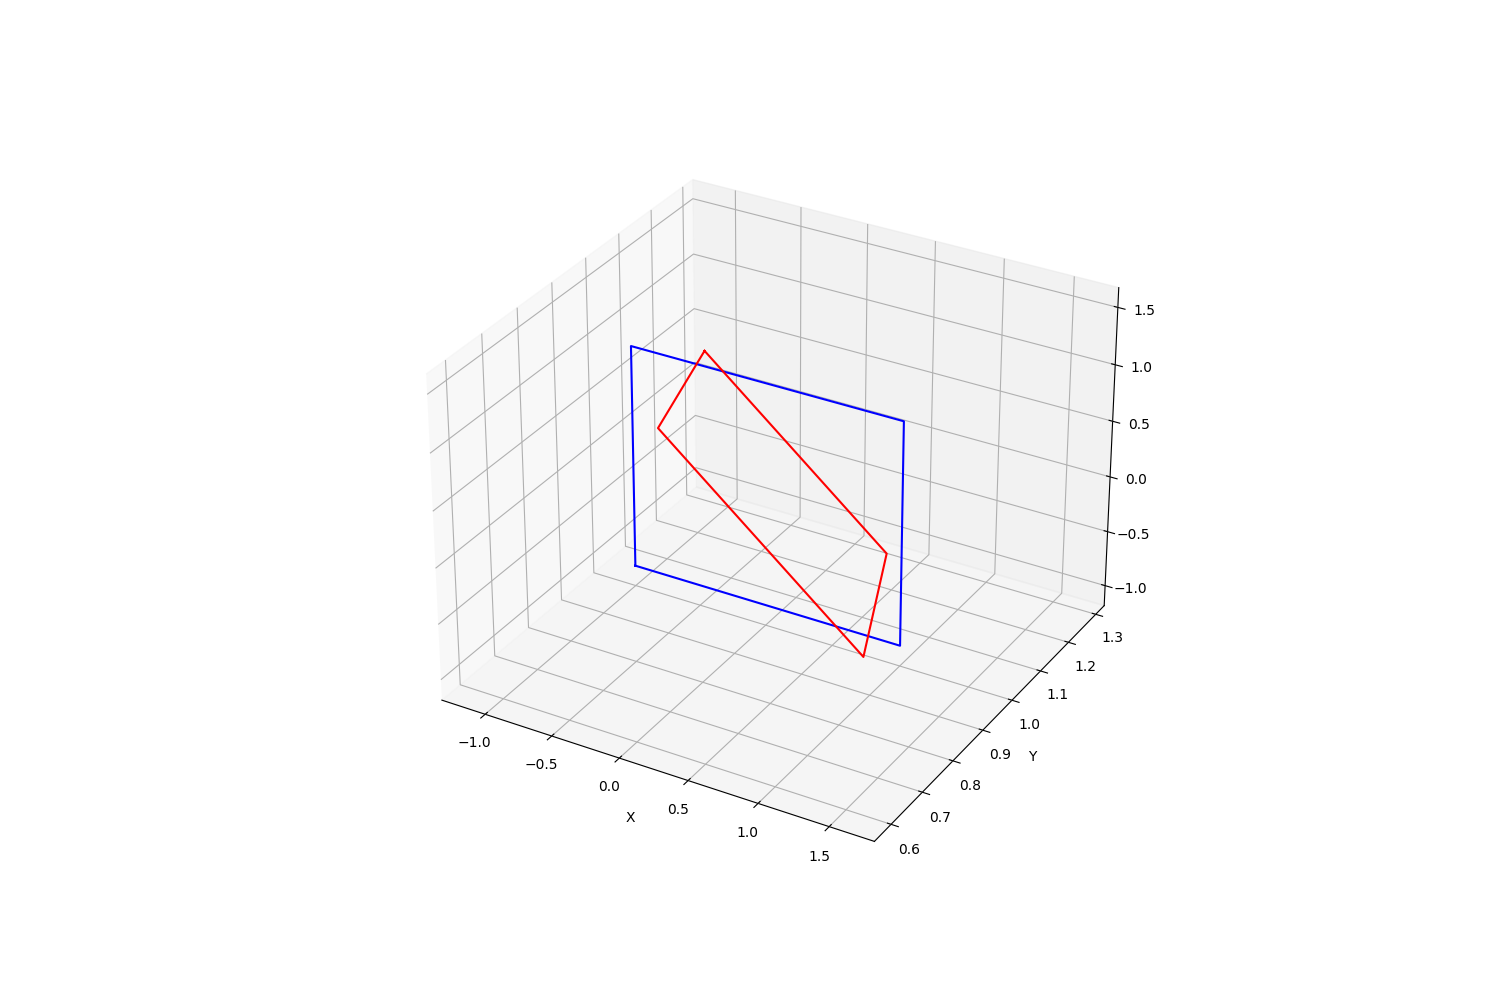

In [62]:
ax = plot_3D_setup()
P.plot(ax, color='b')
Q.plot(ax, color='r')

In [ ]:
# Extract parameters
n_p = P.normal
n_q = Q.normal


Solver approach

In [ ]:
import cvxpy as cp

